In [1]:
import torch
import numpy as np
from operator import itemgetter
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(42)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [2]:
torch.__version__

'0.4.0'

In [3]:
import os
os.chdir('/scratch/wpg205')
os.getcwd()

'/scratch/wpg205'

In [4]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [5]:
torch.has_cudnn

True

In [6]:
device

device(type='cuda')

In [5]:
ft_home = './'
words_to_load = 50000

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    ordered_words_ft.append(PAD_IDX)
    ordered_words_ft.append(UNK_IDX)
    for t, line in enumerate(f):
        i = t + 2 
        if t >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

loaded_embeddings_ft_torch = torch.tensor(loaded_embeddings_ft, requires_grad = True)
del loaded_embeddings_ft

In [8]:
#test
print(ordered_words_ft[words_ft['the']])
print(ordered_words_ft[words_ft['test']])
print(ordered_words_ft[words_ft['is']])
print(ordered_words_ft[words_ft['passed']])

the
test
is
passed


In [9]:
snli_train = pd.read_csv('snli_train.tsv', sep='\t') 
#snli_train = snli_train.iloc[:10000,:]
snli_train['sentence1'] = snli_train['sentence1'].str.split()
snli_train['sentence2'] = snli_train['sentence2'].str.split()

snli_val = pd.read_csv('snli_val.tsv', sep='\t') 
#snli_val = snli_val.iloc[:10000,:]
snli_val['sentence1'] = snli_val['sentence1'].str.split()
snli_val['sentence2'] = snli_val['sentence2'].str.split()

snli_train['label'].replace('neutral',0, inplace=True)
snli_train['label'].replace('entailment',1, inplace = True)
snli_train['label'].replace('contradiction',2, inplace = True)

snli_val['label'].replace('neutral',0, inplace=True)
snli_val['label'].replace('entailment',1, inplace = True)
snli_val['label'].replace('contradiction',2, inplace = True)

data_tup_train = zip(snli_train.sentence1,snli_train.sentence2,snli_train.label)
data_tup_val = zip(snli_val.sentence1,snli_val.sentence2,snli_val.label)

del snli_train
del snli_val

In [10]:
Max_sen_length = 82

class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, char2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.sent1,self.sent2,self.target_list = zip(*data_tuple)
        assert (len(self.sent1) == len(self.target_list))
        assert (len(self.sent2) == len(self.target_list))
        self.char2id = char2id

    def __len__(self):
        return len(self.sent1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx_1 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.sent1[key][:Max_sen_length]]
        char_idx_2 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.sent2[key][:Max_sen_length]]
        label = self.target_list[key]
        return [char_idx_1, char_idx_2,len(char_idx_1),len(char_idx_2),label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list = []
    length_list_2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list.append(datum[2])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]),
                                pad_width=((0,Max_sen_length-datum[2])),
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[1]),
                                pad_width=((0,Max_sen_length-datum[3])),
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec1)
        data_list_2.append(padded_vec2)
        

    ordering1 = np.linspace(0, len(data_list_1),len(data_list_1), endpoint = False)
    ordering2 = np.linspace(0, len(data_list_2),len(data_list_2), endpoint = False)
      
    ind_dec_order = np.argsort(length_list)[::-1]
    ind_dec_order_2 = np.argsort(length_list_2)[::-1]
    
    ordering1 = ordering1[ind_dec_order]
    ordering2 = ordering2[ind_dec_order_2]
        
    data_list_1 = np.array(data_list_1)[ind_dec_order]
    data_list_2 = np.array(data_list_2)[ind_dec_order_2]
                
    length_list = np.array(length_list)[ind_dec_order]
    length_list_2 = np.array(length_list_2)[ind_dec_order_2]
    
    
    mask1 = np.array(data_list_1)
    mask2 = np.array(data_list_2)
    
    mask1[mask1 > 0] = 1
    mask2[mask2 > 0] = 1
    
    
    ###need to mask padded values###
    
                
    #label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)), \
            torch.LongTensor(length_list),torch.LongTensor(length_list_2), \
            torch.LongTensor(label_list), ordering1, ordering2, \
            torch.from_numpy(mask1).to(device), torch.from_numpy(mask2).to(device)]


In [11]:
train_dataset = VocabDataset(data_tup_train, words_ft)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(data_tup_val, words_ft)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

del train_dataset
del val_dataset

In [6]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size,kernel = 3):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding = nn.Embedding.from_pretrained(loaded_embeddings_ft_torch, freeze = False).to(device)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel, padding=1).to(device)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel, padding=1).to(device)

        self.linear1 = nn.Linear(hidden_size*2, 200).to(device)
        self.linear2 = nn.Linear(200, 100).to(device)
        self.linear = nn.Linear(100, num_classes).to(device)

    def forward(self, x1,x2,lengths1,lengths2, ordering1, ordering2, mask1, mask2):
        batch_size, seq_len = x1.size()
        """
        mask1_size1 = mask1.size(0)
        mask1_size2 = mask1.size(1)
        
        mask2_size1 = mask2.size(0)
        mask2_size2 = mask2.size(1)
        
        mask1.unsqueeze_(-1)
        mask1 = mask1.expand(mask1_size1,mask1_size2,200).to(torch.float).to(device)
        
        mask2.unsqueeze_(-1)
        mask2 = mask2.expand(mask2_size1,mask2_size2,200).to(torch.float).to(device)
        """
        
        m1 = torch.zeros([x1.size(0), x1.size(1)]).to(device)
        m2 = torch.zeros([x2.size(0), x2.size(1)]).to(device)
        
        m1[x1 == 1] = 1
        m2[x2 == 1] = 1

        embed1 = self.embedding(x1).to(device)
        embed2 = self.embedding(x2).to(device)
        
        m1 = m1.unsqueeze(-1).expand_as(embed1)
        m2 = m2.unsqueeze(-1).expand_as(embed2)
        
        embed1 = embed1.to(torch.float)
        embed2 = embed2.to(torch.float)
        
        m1 = m1.to(torch.float)
        m2 = m2.to(torch.float)

        embed1 = m1 * embed1+ (1-m1) * embed1.clone().detach()
        embed2 = m2 * embed2+ (1-m2) * embed2.clone().detach()        
        
        hidden = self.conv1(embed1.transpose(1,2)).transpose(1,2).to(device)
        #hidden = hidden*mask1.to(device)
        drop1  = nn.Dropout()
        hidden = drop1(hidden)

        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, -1, hidden.size(-1))
        #hidden = hidden*mask1.to(device)
        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2).to(device)
        #hidden = hidden*mask1.to(device)
        hidden = drop1(hidden)
        
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, -1, hidden.size(-1))
        #hidden = hidden*mask1.to(device)
        hidden = hidden.max(dim = 1)[0]
        #hidden = torch.sum(hidden, dim=1)
        #print(hidden.size())
        
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2).to(device)
        #hidden2 = hidden2*mask2.to(device)
        hidden2 = drop1(hidden2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, -1, hidden2.size(-1))
        #hidden2 = hidden2*mask2.to(device)
        
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2).to(device)
        #hidden2 = hidden2*mask2.to(device)
        hidden2 = drop1(hidden2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, -1, hidden2.size(-1))
        #hidden2 = hidden2*mask2.to(device)
        hidden2 = hidden2.max(dim = 1)[0]
        #hidden2 = torch.sum(hidden2, dim=1)
        
        
        reverse1 = np.argsort(ordering1)
        reverse2 = np.argsort(ordering2)
    
        cnn_out1 = hidden[reverse1,:]
        cnn_out2 = hidden2[reverse2,:]
        #print(cnn_out1.size())
        #cnn_out1 = cnn_out1[:,-1]
        #cnn_out2 = cnn_out2[:,-1]
        #print(cnn_out1.size())
        
        cnn_out = torch.cat((cnn_out1,cnn_out2), 1)
        
        cnn_out = F.relu(self.linear1(cnn_out))
        cnn_out = F.relu(self.linear2(cnn_out))
        logits = self.linear(cnn_out)
        return logits

In [13]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    total_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data1,data2,lengths1,lengths2,labels,ordering1,ordering2, mask1, mask2 in loader:
            outputs = F.softmax(model(data1.to(device),data2.to(device), lengths1.to(device),\
                                      lengths2.to(device),ordering1,ordering2,mask1,mask2), dim=0)
            predicted = outputs.max(1, keepdim=True)[1]
            loss = criterion(outputs, labels.to(device))
            total_loss += loss/labels.to(device).size(0)
            total += labels.to(device).size(0)
            correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
        return (100 * correct / total), total_loss

In [14]:
model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(words_ft), kernel = 5)

learning_rate = 3e-5
num_epochs = 7 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_loss_vals = []
train_acc_vals = []
val_loss_vals = []
val_acc_vals = []
for epoch in range(num_epochs):
    for i, (data1,data2,lengths1,lengths2,labels,ordering1,ordering2,mask1,mask2) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device),data2.to(device),lengths1.to(device),lengths2.to(device),\
                        ordering1,ordering2,mask1, mask2)
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        
        if i > 0 and i % 1000 == 0:
            print("lossing")
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            train_acc, train_loss = test_model(train_loader, model)
            train_loss_vals.append(train_loss)
            train_acc_vals.append(train_acc)
            val_loss_vals.append(val_loss)
            val_acc_vals.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}, Train Loss: {}'.format(
                       epoch+1, num_epochs, i+1, total_step, val_acc, train_acc,train_loss))


lossing
Epoch: [1/7], Step: [1001/3125], Validation Acc: 44.9, Train Acc: 47.09, Train Loss: 106.90717315673828
lossing
Epoch: [1/7], Step: [2001/3125], Validation Acc: 46.6, Train Acc: 50.576, Train Loss: 106.55365753173828
lossing
Epoch: [1/7], Step: [3001/3125], Validation Acc: 53.6, Train Acc: 53.687, Train Loss: 106.406005859375
lossing
Epoch: [2/7], Step: [1001/3125], Validation Acc: 56.0, Train Acc: 56.777, Train Loss: 106.11732482910156
lossing
Epoch: [2/7], Step: [2001/3125], Validation Acc: 56.4, Train Acc: 57.85, Train Loss: 105.96537780761719
lossing
Epoch: [2/7], Step: [3001/3125], Validation Acc: 58.2, Train Acc: 58.604, Train Loss: 105.77066802978516
lossing
Epoch: [3/7], Step: [1001/3125], Validation Acc: 59.0, Train Acc: 59.558, Train Loss: 105.71884155273438
lossing
Epoch: [3/7], Step: [2001/3125], Validation Acc: 57.6, Train Acc: 60.01, Train Loss: 105.6152114868164
lossing
Epoch: [3/7], Step: [3001/3125], Validation Acc: 59.2, Train Acc: 60.455, Train Loss: 105.5306

In [24]:
torch.tensor([1,2,3]).cuda()

tensor([ 1,  2,  3], device='cuda:0')

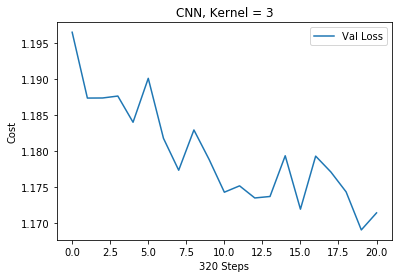

In [20]:
plt.clf()
fig = plt.figure()
plt.title('CNN, Kernel = 3')
plt.xlabel('320 Steps')
plt.ylabel('Cost')
#plt.plot(train_loss_vals, label='Train Loss')
plt.plot(val_loss_vals, label='Val Loss')
plt.legend(loc='best')
fig.savefig('CNN_1_val.png')

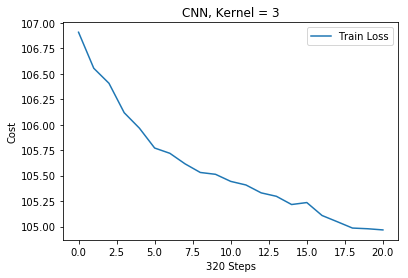

In [21]:
plt.clf()
fig = plt.figure()
plt.title('CNN, Kernel = 3')
plt.xlabel('320 Steps')
plt.ylabel('Cost')
plt.plot(train_loss_vals, label='Train Loss')
#plt.plot(val_loss_vals, label='Val Loss')
plt.legend(loc='best')
fig.savefig('CNN_1_train.png')

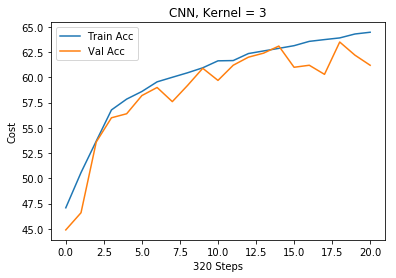

In [23]:
plt.clf()
fig = plt.figure()
plt.title('CNN, Kernel = 3')
plt.xlabel('320 Steps')
plt.ylabel('Cost')
plt.plot(train_acc_vals, label='Train Acc')
plt.plot(val_acc_vals, label='Val Acc')
plt.legend(loc='best')
fig.savefig('CNN_1_accs.png')

In [18]:
def CNN_kern(kernel):
    print(kernel)
    model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(words_ft), kernel = kernel)

    learning_rate = 3e-4
    num_epochs = 8 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    train_loss_vals = []
    train_acc_vals = []
    val_loss_vals = []
    val_acc_vals = []
    for epoch in range(num_epochs):
        for i, (data1,data2,lengths1,lengths2,labels,ordering1,ordering2,mask1,mask2) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.to(device),data2.to(device),lengths1.to(device),lengths2.to(device),\
                            ordering1,ordering2,mask1, mask2)
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations

            if i > 0 and i % 1000 == 0:
                print("lossing")
                # validate
                val_acc, val_loss = test_model(val_loader, model)
                train_acc, train_loss = test_model(train_loader, model)
                train_loss_vals.append(train_loss)
                train_acc_vals.append(train_acc)
                val_loss_vals.append(val_loss)
                val_acc_vals.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format(
                           epoch+1, num_epochs, i+1, total_step, val_acc, train_acc ))
        
    return train_loss_vals, train_acc_vals, val_loss_vals, val_acc_vals


In [19]:
kernel_sizes = [3,4,5,6,10,20]

training_losses = []
val_losses = []
training_accs = []
val_accs = []

criterion = torch.nn.CrossEntropyLoss()
    
for x in kernel_sizes:
    a,b,c,d = CNN_kern(x)
    training_losses.append(a)
    training_accs.append(b)
    val_losses.append(c)
    val_accs.append(d)
    pkl.dump(training_losses, open("training_losses.p", "wb"))
    pkl.dump(val_losses, open("val_losses.p", "wb"))
    pkl.dump(training_accs, open("training_accs.p", "wb"))
    pkl.dump(val_accs, open("val_accs.p", "wb"))

3
lossing
Epoch: [1/8], Step: [1001/3125], Validation Acc: 59.4, Train Acc: 57.339
lossing
Epoch: [1/8], Step: [2001/3125], Validation Acc: 59.4, Train Acc: 60.476
lossing
Epoch: [1/8], Step: [3001/3125], Validation Acc: 58.7, Train Acc: 61.531
lossing
Epoch: [2/8], Step: [1001/3125], Validation Acc: 58.9, Train Acc: 62.238
lossing
Epoch: [2/8], Step: [2001/3125], Validation Acc: 60.9, Train Acc: 62.577
lossing
Epoch: [2/8], Step: [3001/3125], Validation Acc: 60.1, Train Acc: 63.036
lossing
Epoch: [3/8], Step: [1001/3125], Validation Acc: 62.1, Train Acc: 63.468
lossing
Epoch: [3/8], Step: [2001/3125], Validation Acc: 62.3, Train Acc: 64.212
lossing
Epoch: [3/8], Step: [3001/3125], Validation Acc: 62.2, Train Acc: 64.178
lossing
Epoch: [4/8], Step: [1001/3125], Validation Acc: 61.4, Train Acc: 64.668
lossing
Epoch: [4/8], Step: [2001/3125], Validation Acc: 61.2, Train Acc: 64.466
lossing
Epoch: [4/8], Step: [3001/3125], Validation Acc: 63.3, Train Acc: 64.957
lossing
Epoch: [5/8], Step

lossing
Epoch: [3/8], Step: [1001/3125], Validation Acc: 59.8, Train Acc: 62.959
lossing
Epoch: [3/8], Step: [2001/3125], Validation Acc: 63.2, Train Acc: 63.742
lossing
Epoch: [3/8], Step: [3001/3125], Validation Acc: 59.1, Train Acc: 63.375
lossing
Epoch: [4/8], Step: [1001/3125], Validation Acc: 59.7, Train Acc: 63.195
lossing
Epoch: [4/8], Step: [2001/3125], Validation Acc: 59.4, Train Acc: 63.799
lossing
Epoch: [4/8], Step: [3001/3125], Validation Acc: 62.0, Train Acc: 65.017
lossing
Epoch: [5/8], Step: [1001/3125], Validation Acc: 62.2, Train Acc: 65.4
lossing
Epoch: [5/8], Step: [2001/3125], Validation Acc: 61.4, Train Acc: 65.738
lossing
Epoch: [5/8], Step: [3001/3125], Validation Acc: 61.2, Train Acc: 65.668
lossing
Epoch: [6/8], Step: [1001/3125], Validation Acc: 62.3, Train Acc: 65.97
lossing
Epoch: [6/8], Step: [2001/3125], Validation Acc: 60.9, Train Acc: 66.209
lossing
Epoch: [6/8], Step: [3001/3125], Validation Acc: 62.0, Train Acc: 67.665
lossing
Epoch: [7/8], Step: [10

In [23]:
max_val_accs = []
for x in val_accs:
    max_val_accs.append(max(x))


In [27]:
print(pd.DataFrame({"Kernel_size":kernel_sizes,"Validation_acc":max_val_accs}).T.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &     0 &     1 &     2 &     3 &     4 &     5 \\
\midrule
Kernel\_size    &   3.0 &   4.0 &   5.0 &   6.0 &  10.0 &  20.0 \\
Validation\_acc &  65.4 &  65.2 &  64.1 &  63.3 &  63.2 &  62.0 \\
\bottomrule
\end{tabular}



In [8]:
def total_params(model):
    param_total = 0
    for x in model.parameters():
        if x.requires_grad:
            store = 1
            for y in range(len(x.size())):
                store = store*x.size(y)
            param_total += store
    
    #(these are untrained embeddings)
    total_embeddings = 50001*300
    param_total -= total_embeddings
    return param_total

In [13]:
kernel_sizes = [3,4,5,6,10,20]
params_list = []
for x in kernel_sizes:
    model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(words_ft), kernel = x)
    params_list.append(total_params(model))

In [14]:
params_list

[401303, 501303, 601303, 701303, 1101303, 2101303]